In [1]:
import pandas as pd
data_df = pd.read_csv('train.csv')
data_df.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np 
random_state=1
train_df, test_df = train_test_split(data_df, test_size=2000, random_state=random_state)
train_df, valid_df = train_test_split(train_df, test_size=2000, random_state=random_state)
print('train data size: ', len(train_df))
print('valid data size: ', len(valid_df))
print('test  data size: ', len(test_df))

X_train, Y_train = (np.array(train_df['filename']), np.array(train_df['label']))
X_valid, Y_valid = (np.array(valid_df['filename']), np.array(valid_df['label']))
X_test, Y_test = (np.array(test_df['filename']), np.array(test_df['label']))

print(X_train[0:4])
print(Y_train[0:4])

train data size:  96000
valid data size:  2000
test  data size:  2000
['train/1636.jpg' 'train/60389.jpg' 'train/10990.jpg' 'train/8179.jpg']
['6+(5-7)=4' '7-5-4=-2' '6*(6-7)=-6' '(1+0)+8=9']


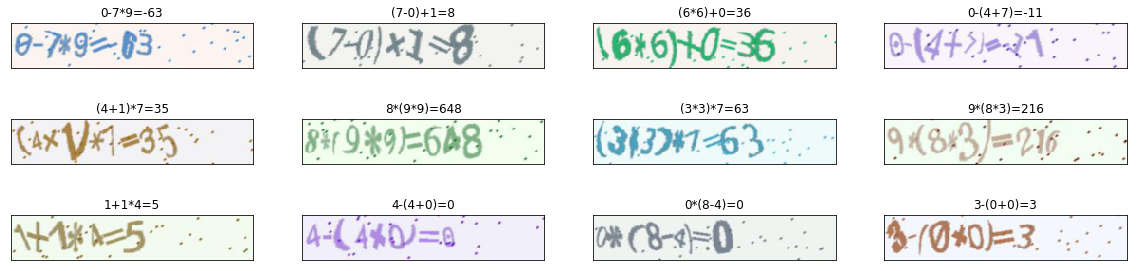

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 48))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(20,5))
for i in range(12):
    label = Y_test[i]
    ax = fig.add_subplot(3,4, i+1,xticks=[],yticks=[], title=label)
    visualize_img(X_test[i], ax)

In [ ]:
# img = cv2.imread(X_train[0])
# print(img.shape)
# print(img)

In [ ]:
# test = map(lambda x: x **2, range(9))
# print(test)
# for i in test:
#     print(i) 
# help(list)

In [4]:
from collections import defaultdict

char_counter= defaultdict(lambda: 0)

def count(x):
    for i in x:
        char_counter[i] += 1

labels = np.array(data_df['label'])

list(map(count, labels))
print(char_counter)
print('max lenght: ', np.max(list(map(lambda x: len(x), labels))))

defaultdict(<function <lambda> at 0x7f0c909c4f28>, {'(': 66487, '0': 46522, '+': 66517, ')': 66487, '9': 37251, '=': 100000, '*': 66668, '8': 40008, '6': 42535, '7': 38880, '1': 64228, '5': 42278, '4': 45867, '-': 89396, '3': 44442, '2': 51072})
max lenght:  11


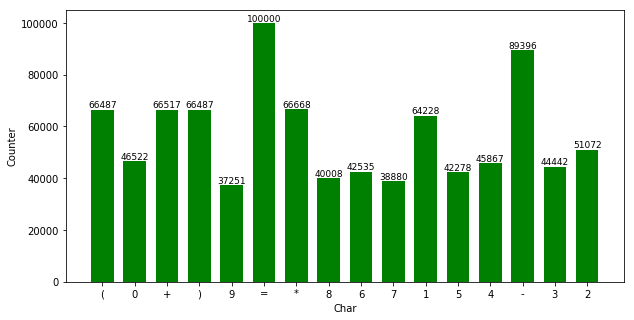

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.bar(char_counter.keys(), char_counter.values(), width=0.7, color='g')
plt.ylabel('Counter')
plt.xlabel('Char')
for key, value in char_counter.items():
    plt.text(key,value,'%d' % value, ha='center', va='bottom', fontsize=9)
    

In [6]:
char_vector = np.array(['0','1','2','3','4','5','6','7','8','9','(',')','+',"-",'*','='])
# print(len(char_counter.keys()))
# print(len(char_vector))
print(char_vector.shape)

img_w = 256
img_h = 48
n_classes = len(char_vector) + 1 # add one to present other class
max_exp_len = 11


def label_to_char(label):
    return char_vector[label]

def char_to_label(char):
    return np.argwhere(char_vector == char)[0][0]

def labels_to_expression(labels):
    return ''.join(list(map(lambda x: label_to_char(x),labels)))

def expression_to_labels(expression):
    return list(map(lambda x: char_to_label(x),list(expression)))

def path_to_tensor(img_path, img_w, img_h):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_w, img_h))
    img = img.T
    img = img.astype(np.float32)
    img = (img / 255.0) * 2 - 1.0
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    return img

def paths_to_tensor(img_paths, img_w, img_h):
    list_of_tensors = [path_to_tensor(path, img_w, img_h)  for path in img_paths]
    return np.vstack(list_of_tensors)
    
    
l1 = char_to_label('=')
c1 = label_to_char(l1)
print(l1)
print(c1)

ls1 = [1,12, 7, 14, 9, 15, 1, 2]
ex1 = labels_to_expression(ls1)
ls2 = expression_to_labels(ex1)
print(ex1)
print(ls2)

tensor_t = path_to_tensor(X_train[0], img_w, img_h)
print(tensor_t.shape)
# print(img_test)
tensors_list = paths_to_tensor(X_test, img_w, img_h)
print(tensors_list.shape)


(16,)
15
=
1+7*9=12
[1, 12, 7, 14, 9, 15, 1, 2]
(1, 256, 48, 1)
(2000, 256, 48, 1)


In [24]:
import cv2
import random

class TensorGenerator:
    
    def __init__(self, img_paths, expressions, img_w, img_h, batch_size, max_exp_len):
        self.img_paths = img_paths
        self.expressions = expressions
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.max_exp_len = max_exp_len
        self.n = len(img_paths)
        self.indexes = list(range(self.n))
        self.next_index = 0
    
    def next_sample(self):
        index = self.indexes[self.next_index]
        self.next_index += 1
        if self.next_index >= self.n:
            self.next_index = 0
            random.shuffle(self.indexes)
        path = self.img_paths[index]
        labels = expression_to_labels(self.expressions[index])
        img = path_to_tensor(path, self.img_w, self.img_h)
        return img, labels
        
    def next_batch(self):
        while True:
            
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_exp_len])
            
            input_length = np.ones([self.batch_size, 1]) * 32 # equal to the model define before push to rnn
            label_length = np.zeros([self.batch_size, 1])
            
            for i in range(self.batch_size):
                img, labels = self.next_sample()
                X_data[i] = img[0]
                Y_data[i][0: len(labels)] = labels
                label_length[i] = len(labels)
#                 print(labels_to_expression(labels))
                
            inputs = {
                'the_inputs': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            
            outputs = {
                'ctc':np.zeros([self.batch_size])
            }
#             print(inputs)
            
            yield(inputs, outputs)

In [27]:
generator_test = TensorGenerator(X_train, Y_train, img_w, img_h, 20, 11)
f = generator_test.next_batch()
r = f.__next__()
# r = r[0]['the_inputs'].shape
print(r)

(20, 256, 48, 1)


In [7]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import BatchNormalization, Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
#     y_pred = y_pred[:,2:]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(training):

    K.set_learning_phase(training)
    
    # help(Model.fit_generator)
    input_shape = (img_w, img_h, 1) # (256, 48, 1)

    inputs = Input(name='the_inputs', shape=input_shape, dtype='float32') # (None, 256, 48, 1)

    inner = Conv2D(64, (3,3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) # (None, 256, 48, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner) # (None, 128, 24, 64)
    
    inner = Conv2D(128, (3,3), padding='same', name='conv2', kernel_initializer='he_normal')(inner) # (None, 128, 24, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,1), name='max2')(inner) # (None, 64, 24, 128)

    inner = Conv2D(256, (3,3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) # (None, 64, 24, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3,3), padding='same', name='conv4', kernel_initializer='he_normal')(inner) # (None, 64, 24, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1,2), name='max3')(inner) # (None, 64, 6, 256)

    inner = Conv2D(512, (3,3), padding='same', name='conv5', kernel_initializer='he_normal')(inner) # (None, 64, 12, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (2,2), padding='same', name='conv6', kernel_initializer='he_normal')(inner) # (None, 64, 12, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max4')(inner) # (None, 32, 6, 512)

    inner = Conv2D(1024, (1,1), padding='same', name='conv7', kernel_initializer='he_normal')(inner) # (None, 32, 6, 1024)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    inner = Reshape(target_shape=((32, 6 * 1024)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_1')(inner)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_1b')(inner)
    lstm1_merged = add([lstm_1, lstm_1b])
    lstm1_merged = BatchNormalization()(lstm1_merged)

    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_2b')(lstm1_merged)
    lstm2_merged = add([lstm_2, lstm_2b])
    lstm2_merged = BatchNormalization()(lstm2_merged)

    inner = Dense(n_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged)
    y_pred = Activation('softmax', name='softmax')(inner)
    
    labels = Input(name='the_labels', shape=[max_exp_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    if training:
        model = Model(inputs=[inputs, labels,input_length, label_length], outputs=loss_out)
    else:    
        model = Model(inputs=[inputs], outputs=y_pred)  
#     model.summary()
    return model


Using TensorFlow backend.


In [33]:
help(Model)

Help on class Model in module keras.engine.training:

class Model(keras.engine.network.Network)
 |  The `Model` class adds training & evaluation routines to a `Network`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.network.Network
 |      keras.engine.base_layer.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function.
 |              See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary or a list of losses.
 |              The loss value 

In [36]:
model = get_Model(training=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 256, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 48, 64)  640         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 48, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 48, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

In [56]:
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 128
batch_size_val = 32
epochs =10

tiger_train = TensorGenerator(X_train[0:2000], Y_train[0:2000], img_w, img_h, batch_size, max_exp_len)
tiger_valid = TensorGenerator(X_valid[0:500], Y_valid[0:500], img_w, img_h, batch_size_val, max_exp_len)

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='checkpoint/CRNN--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta())

In [42]:
# help(model.fit_generator)

In [57]:
model.fit_generator(generator=tiger_train.next_batch(),
                   steps_per_epoch=int(tiger_train.n / batch_size),
                   epochs=epochs,
                   callbacks=[checkpoint],
                   validation_data=tiger_valid.next_batch(),
                   validation_steps=int(tiger_valid.n / batch_size_val)
                   )

Epoch 1/10
15/15 [==============================] - 14s 956ms/step - loss: 24.5125 - val_loss: 20.0060

Epoch 00001: saving model to checkpoint/CRNN--01--20.006.hdf5
Epoch 2/10
15/15 [==============================] - 10s 670ms/step - loss: 16.4478 - val_loss: 14.3817

Epoch 00002: saving model to checkpoint/CRNN--02--14.382.hdf5
Epoch 3/10
15/15 [==============================] - 10s 669ms/step - loss: 13.0560 - val_loss: 13.9994

Epoch 00003: saving model to checkpoint/CRNN--03--13.999.hdf5
Epoch 4/10
15/15 [==============================] - 10s 665ms/step - loss: 11.6712 - val_loss: 12.6049

Epoch 00004: saving model to checkpoint/CRNN--04--12.605.hdf5
Epoch 5/10
15/15 [==============================] - 10s 659ms/step - loss: 10.6828 - val_loss: 11.3904

Epoch 00005: saving model to checkpoint/CRNN--05--11.390.hdf5
Epoch 6/10
15/15 [==============================] - 10s 662ms/step - loss: 9.4202 - val_loss: 10.6468

Epoch 00006: saving model to checkpoint/CRNN--06--10.647.hdf5
Epoch

In [9]:
X_tensor_test = paths_to_tensor(X_test, img_w, img_h)

In [8]:
model = get_Model(training=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 256, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 48, 64)  640         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 48, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 48, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

In [10]:
model.load_weights('./checkpoint/CRNN--20--0.025-0224.hdf5')

In [11]:
import itertools
out_tensor = model.predict(X_tensor_test)
def out_tensor_to_expression(out_tensor):
    Y_pred = list()
    for tensor in out_tensor:
        out_tensor_argmax = np.argmax(tensor, axis=1)
        out_best = [k for k, g in itertools.groupby(out_tensor_argmax)]
        out_best = list(filter(lambda x: x < 16, out_best))
        Y_pred.append(labels_to_expression(out_best))
    return Y_pred

Y_pred = np.array(out_tensor_to_expression(out_tensor))

In [14]:
tt = np.argmax(out_tensor[3], axis=1)
print(tt)
print(Y_test[3])

[ 0 13 10  4 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 12 12  7 11 11
 15 15 15 15 13  1 16  1]
0-(4+7)=-11


In [20]:
total = 0
acc = 0

letter_total = 0
letter_acc = 0

err_pre_indexs = list()
for pre, true in zip(Y_pred, Y_test):
    print('pre: ', pre, '\t true: ', true)
    for i in range(min(len(pre), len(true))):
        if pre[i] == true[i]:
            letter_acc += 1
    letter_total += max(len(pre), len(true))
    if pre == true:
        acc += 1
    else:
        err_pre_indexs.append(total)
        print('**** occur error prediction ****')
    total += 1


print('letter accuracy: %.4f' % (letter_acc / float(letter_total)))
print('total  accuracy: %.4f' % (acc / total)) 

pre:  0-7*9=-63 	 true:  0-7*9=-63
pre:  (7-0)+1=8 	 true:  (7-0)+1=8
pre:  (6*6)+0=36 	 true:  (6*6)+0=36
pre:  0-(4+7)=-11 	 true:  0-(4+7)=-11
pre:  (4+1)*7=35 	 true:  (4+1)*7=35
pre:  8*(9*9)=648 	 true:  8*(9*9)=648
pre:  (3*3)*7=63 	 true:  (3*3)*7=63
pre:  9*(8*3)=216 	 true:  9*(8*3)=216
pre:  1+1*4=5 	 true:  1+1*4=5
pre:  4-(4+0)=0 	 true:  4-(4+0)=0
pre:  0*(8-4)=0 	 true:  0*(8-4)=0
pre:  3-(0+0)=3 	 true:  3-(0+0)=3
pre:  8+6+6=20 	 true:  8+6+6=20
pre:  0+(4-9)=-5 	 true:  0+(4-9)=-5
pre:  3+7+3=13 	 true:  3+7+3=13
pre:  9-9+7=7 	 true:  9-9+7=7
pre:  8-3-1=4 	 true:  8-3-1=4
pre:  (8+4)*2=24 	 true:  (8+4)*2=24
pre:  (0-3)-0=-3 	 true:  (0-3)-0=-3
pre:  2*(0*8)=0 	 true:  2*(0*8)=0
pre:  0*9*2=0 	 true:  0*9*2=0
pre:  (0*7)+1=1 	 true:  (0*7)+1=1
pre:  3-(0+1)=2 	 true:  3-(0+1)=2
pre:  (5-5)+7=7 	 true:  (5-5)+7=7
pre:  (6+8)*9=126 	 true:  (6+8)*9=126
pre:  3+8-5=6 	 true:  3+8-5=6
pre:  1+6+4=11 	 true:  1+6+4=11
pre:  7*(4*5)=140 	 true:  7*(4*5)=140
pre:  (5+3)+3=

pre:  8-1*5=3 	 true:  8-1*5=3
pre:  8+(8+3)=19 	 true:  8+(8+3)=19
pre:  1+(1+4)=6 	 true:  1+(1+4)=6
pre:  7*6+7=49 	 true:  7*6+7=49
pre:  (0-5)-6=-11 	 true:  (0-5)-6=-11
pre:  (0*8)*6=0 	 true:  (0*8)*6=0
pre:  (4+6)+6=16 	 true:  (4+6)+6=16
pre:  5*2-4=6 	 true:  5*2-4=6
pre:  4+(3-0)=7 	 true:  4+(3-0)=7
pre:  3*(2*1)=6 	 true:  3*(2*1)=6
pre:  (8+8)-0=16 	 true:  (8+8)-0=16
pre:  (7-2)-3=2 	 true:  (7-2)-3=2
pre:  4*7*6=168 	 true:  4*7*6=168
pre:  7-(3*3)=-2 	 true:  7-(3*3)=-2
pre:  2-(1*1)=1 	 true:  2-(1*1)=1
pre:  9*(7-4)=27 	 true:  9*(7-4)=27
pre:  7-(3-0)=4 	 true:  7-(3-0)=4
pre:  6+9*5=51 	 true:  6+9*5=51
pre:  1-1+6=6 	 true:  1-1+6=6
pre:  3+(1-1)=3 	 true:  3+(1-1)=3
pre:  (4-1)*5=15 	 true:  (4-1)*5=15
pre:  8-7-4=-3 	 true:  8-7-4=-3
pre:  8*9+2=74 	 true:  8*9+2=74
pre:  (0+4)+4=8 	 true:  (0+4)+4=8
pre:  (8-3)-8=-3 	 true:  (8-3)-8=-3
pre:  (4+6)+4=14 	 true:  (4+6)+4=14
pre:  3-(6-0)=-3 	 true:  3-(6-0)=-3
pre:  1+(0-3)=-2 	 true:  1+(0-3)=-2
pre:  8*5-1=39 	

pre:  0-(6-3)=-3 	 true:  0-(6-3)=-3
pre:  (2-7)*3=-15 	 true:  (2-7)*3=-15
pre:  1+(9*2)=19 	 true:  1+(9*2)=19
pre:  0+8+6=11 	 true:  0+8+6=14
**** occur error prediction ****
pre:  2-2*5=-8 	 true:  2-2*5=-8
pre:  0-9-0=-9 	 true:  0-9-0=-9
pre:  (4+0)*0=0 	 true:  (4+0)*0=0
pre:  8+5-6=7 	 true:  8+5-6=7
pre:  (0-2)*3=-6 	 true:  (0-2)*3=-6
pre:  3+2-8=-3 	 true:  3+2-8=-3
pre:  3+(4*1)=7 	 true:  3+(4*1)=7
pre:  0+6+1=7 	 true:  0+6+1=7
pre:  (6-5)-3=-2 	 true:  (6-5)-3=-2
pre:  (1-0)+4=5 	 true:  (1-0)+4=5
pre:  (0-2)-0=-2 	 true:  (0-2)-0=-2
pre:  4*8+7=39 	 true:  4*8+7=39
pre:  1+1*8=9 	 true:  1+1*8=9
pre:  4+4+6=14 	 true:  4+4+6=14
pre:  (6+6)-2=10 	 true:  (6+6)-2=10
pre:  7+9+3=19 	 true:  7+9+3=19
pre:  (1-6)*1=-5 	 true:  (1-6)*1=-5
pre:  (1-2)+7=6 	 true:  (1-2)+7=6
pre:  5*(9-8)=5 	 true:  5*(9-8)=5
pre:  (8+2)*9=90 	 true:  (8+2)*9=90
pre:  1+9-4=6 	 true:  1+9-4=6
pre:  9*(3+6)=81 	 true:  9*(3+6)=81
pre:  1*(7*1)=7 	 true:  1*(7*1)=7
pre:  (8+0)+1=9 	 true:  (8+0)

In [24]:
print('error prediction indexs: ', err_pre_indexs)
print('error cases:')
for i in err_pre_indexs:
    print('pre: ', Y_pred[i], '\t true: ', Y_test[i])

error prediction indexs:  [95, 168, 232, 246, 263, 467, 795, 1533, 1653, 1694, 1728, 1945, 1992]
error cases:
pre:  (1+7)+3=17 	 true:  (7+7)+3=17
pre:  3-(1-0)=4 	 true:  5-(1-0)=4
pre:  9*(6*5)=210 	 true:  9*(6*5)=270
pre:  5+(5-1)=3 	 true:  5+(5-7)=3
pre:  4*5-3=11 	 true:  4*5-3=17
pre:  5-(3-4)=-6 	 true:  5-(3-4)=6
pre:  (7+7)*9=72 	 true:  (7+1)*9=72
pre:  0+8+6=11 	 true:  0+8+6=14
pre:  (4+6)*7=10 	 true:  (4+6)*1=10
pre:  (8*1)-8=48 	 true:  (8*7)-8=48
pre:  3-(4-8)=5 	 true:  3-(4-6)=5
pre:  (1-1)-4=-7 	 true:  (1-4)-4=-7
pre:  (5+3)-8=8 	 true:  (5+3)-8=0


In [39]:
%matplotlib inline

def visualize_error_img(img_path, ax):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 48))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_error_cases(paths, pre_labels, true_labels):
    inner_len = len(paths)
    columns = 4
    rows = int(inner_len - 1 / columns) + 1
    fig = plt.figure(figsize=(20, 1.5 * rows))
    for i in range(inner_len):
        label = 'true:%\t pre:%s' % (true_labels[i],pre_labels[i])
        ax = fig.add_subplot(rows,columns, i+1,xticks=[],yticks=[], title=label)
        visualize_error_img(paths[i], ax)

In [43]:
error_paths = list()
error_preds = list()
error_trues = list()
for i in err_pre_indexs:
    error_paths.append(X_test[i])
    error_preds.append(Y_pred[i])
    error_trues.append(Y_test[i])

show_error_cases(error_paths, error_preds, error_trues)


ValueError: unsupported format character '?' (0x9) at index 6

<Figure size 1440x1404 with 0 Axes>